In [1]:
import mitsuba as mi
mi.set_variant('scalar_rgb')
tent_rfilter = mi.load_dict({'type' : 'tent'})
mi.set_variant("cuda_ad_rgb")
import drjit as dr
from enum import Enum

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

In [2]:
class Scene(Enum):
    COND1 = 1
    COND2 = 2

# Utils

In [3]:
def to_float(x):
    # hacky way to convert Mitsuba float to Python float
    return float(np.array(x))

In [4]:
def plot_res(images_bm, textures_bm, titles, size_factor=3):
    fig, ax = plt.subplots(ncols=2, nrows=len(images_bm), figsize=(8, size_factor*len(images_bm)), squeeze=False)
    for i, (img, tex, title) in enumerate(zip(images_bm, textures_bm, titles)):
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(tex)
        ax[i, 0].set_ylabel(title, size=14)
        ax[i, 0].set_xticks([]); ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([]); ax[i, 1].set_yticks([])
    ax[0, 0].set_title("Rendering", weight='bold', size=14)
    ax[0, 1].set_title("Roughness texture", weight='bold', size=14)
    plt.tight_layout()
    plt.show()

def plot_res2(res_dict, size_factor=3):
    titles = list(res_dict.keys())
    images_bm = [res_dict[title][0] for title in titles]
    textures_bm = [res_dict[title][1] for title in titles]
    plot_res(images_bm, textures_bm, titles, size_factor)

In [5]:
def image_to_bm(image):
    return mi.util.convert_to_bitmap(image)

def params_to_bm(params):
    return mi.util.convert_to_bitmap(params).convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, False)

In [6]:
def reset_scene(scene: Scene):
    return mi.load_file(f"../scenes/roughness_optimization_{scene.value}.xml")

In [7]:
def generate_random_texture(scene_name: Scene, seed=0):
    init_res = 32
    scale = 0.5 if scene_name == Scene.COND1 else 0.3
    opt_res = 512

    # Initialize textured roughness with random values
    np.random.seed(seed)
    initial_values = mi.Bitmap((scale*np.random.uniform(size=init_res**2)).reshape(init_res, init_res, -1))

    # Upsample texture to full resolution
    return mi.TensorXf(np.array(initial_values.resample([opt_res, opt_res], tent_rfilter))[..., np.newaxis])

# Reference scenes rendering

In [8]:
OPT_KEY = 'plane.bsdf.alpha.data'

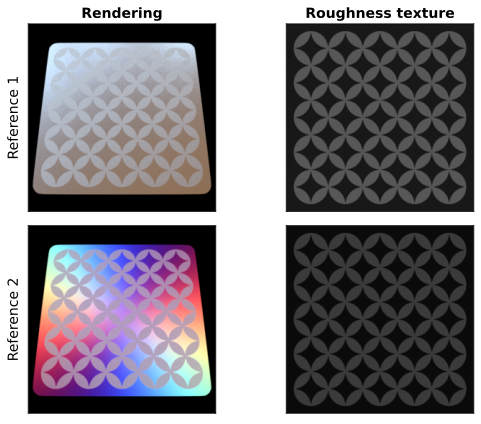

In [9]:
scene_ref = {k: reset_scene(k) for k in Scene}
params = {k: mi.traverse(scene_ref[k]) for k in Scene}

# Render reference images
image_ref = {k: mi.render(scene_ref[k], seed=0, spp=128) for k in Scene}
params_ref = {k: params[k][OPT_KEY] for k in Scene}

image_ref_bm = {k: image_to_bm(image_ref[k])  for k in Scene}
params_ref_bm = {k: params_to_bm(params_ref[k])  for k in Scene}

# Plot
plot_res2({f'Reference {k.value}': (image_ref_bm[k], params_ref_bm[k]) for k in Scene})

# Loss landscape utils

In [10]:
def rel_l1_loss(img, img_ref):
    # Relative L1 loss
    return dr.sum(dr.abs(img - img_ref) / (dr.maximum(dr.abs(img_ref), 0.001))) / len(img)

def mse(img, img_ref):
    return dr.mean(dr.sqr(img - img_ref))

In [11]:
def plot_loss_linear_interp_1D(scene_name: Scene, params_1, params_2, loss_fn=rel_l1_loss, n_samples = 100, title=None, spp=8):
    alphas = np.linspace(0, 1, n_samples)
    losses = []
    for i, alpha in enumerate(alphas):
        scene = reset_scene(scene_name)
        params = mi.traverse(scene)
        params[OPT_KEY] = (1 - alpha) * params_1 + alpha * params_2
        params.update()
        image = mi.render(scene, params, seed=i, spp=spp)
        losses.append(loss_fn(image, image_ref[scene_name]))
    if title is not None:
        plt.title(title)
    plt.plot(alphas, losses)

In [34]:
def plot_loss_bilinear_interp_2D(scene_name: Scene, params_1, params_2, params_3, params_4, loss_fn=rel_l1_loss, n_samples = 10, title=None, spp=8):
    alphas = np.linspace(0, 1, n_samples)
    losses = np.zeros((n_samples, n_samples))
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(alphas):
            scene = reset_scene(scene_name)
            params = mi.traverse(scene)
            params[OPT_KEY] = (1 - alpha) * (1 - beta) * params_1 + (1 - alpha) * beta * params_2 + alpha * (1 - beta) * params_3 + alpha * beta * params_4
            params.update()
            image = mi.render(scene, params, seed=i*len(alphas)+j, spp=spp)
            losses[i, j] = to_float(loss_fn(image, image_ref[scene_name]))
    if title is not None:
        plt.title(title)
    plt.contourf(alphas, alphas, losses)
    plt.colorbar()

In [28]:
def contour_plot_1d(scene_name: Scene, params, dir, loss_fn=rel_l1_loss, n_samples = 100, title=None, spp=8):
    alphas = np.linspace(0, 1, n_samples)
    losses = []
    for i, alpha in enumerate(alphas):
        scene = reset_scene(scene_name)
        params_loc = mi.traverse(scene)
        params_loc[OPT_KEY] = params + alpha * dir
        params_loc.update()
        image = mi.render(scene, params_loc, seed=i, spp=spp)
        losses.append(loss_fn(image, image_ref[scene_name]))
    if title is not None:
        plt.title(title)
    plt.plot(alphas, losses)

In [27]:
def contour_plot_2d(scene_name: Scene, params, dir1, dir2, loss_fn=rel_l1_loss, n_samples = 10, title=None, spp=8):
    # TODO check that the labels are correct
    alphas = np.linspace(0, 1, n_samples)
    losses = np.zeros((n_samples, n_samples))
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(alphas):
            scene = reset_scene(scene_name)
            params_loc = mi.traverse(scene)
            params_loc[OPT_KEY] = dr.clamp(params + alpha * dir1 + beta * dir2, 0.0, 1.0)
            params_loc.update()
            image = mi.render(scene, params_loc, seed=i*len(alphas)+j, spp=spp)
            losses[i, j] = to_float(loss_fn(image, image_ref[scene_name]))
    if title is not None:
        plt.title(title)
    plt.xlabel('dir1')
    plt.ylabel('dir2')
    plt.contourf(alphas, alphas, losses)
    plt.colorbar()

# Interp 1D experiments

## Scene 1

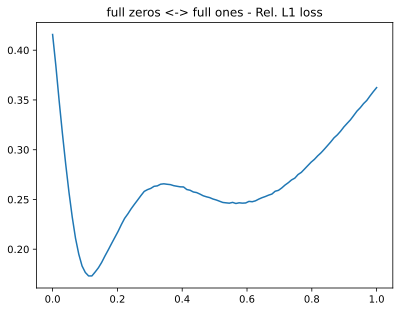

In [52]:
params_1 = mi.TensorXf(np.zeros((512, 512, 1)))
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="full zeros <-> full ones - Rel. L1 loss", loss_fn=rel_l1_loss)

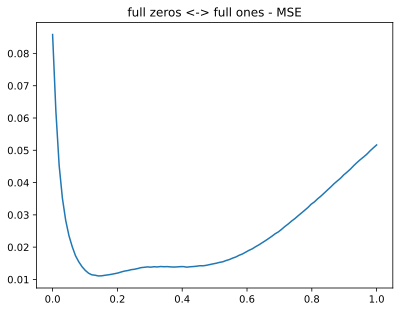

In [53]:
params_1 = mi.TensorXf(np.zeros((512, 512, 1)))
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="full zeros <-> full ones - MSE", loss_fn=mse)

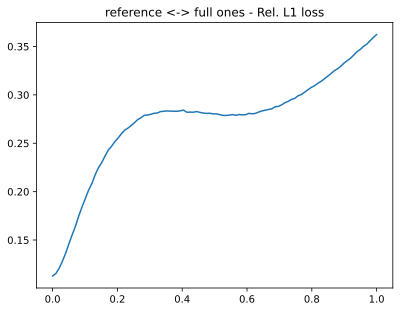

In [54]:
params_1 = mi.TensorXf(params_ref[Scene.COND1])
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> full ones - Rel. L1 loss", loss_fn=rel_l1_loss)

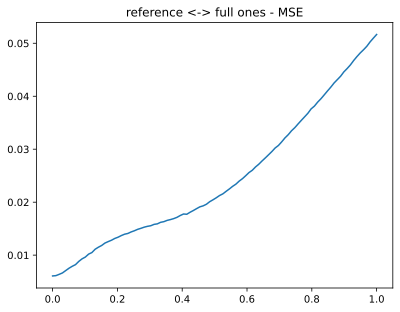

In [55]:
params_1 = mi.TensorXf(params_ref[Scene.COND1])
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> full ones - MSE", loss_fn=mse)

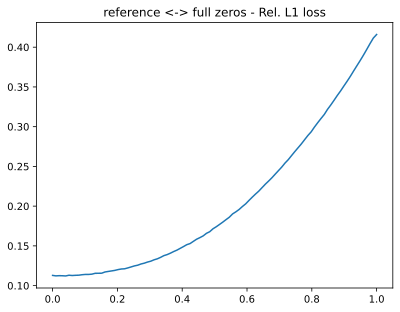

In [56]:
params_1 = mi.TensorXf(params_ref[Scene.COND1])
params_2 = mi.TensorXf(np.zeros((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> full zeros - Rel. L1 loss", loss_fn=rel_l1_loss)

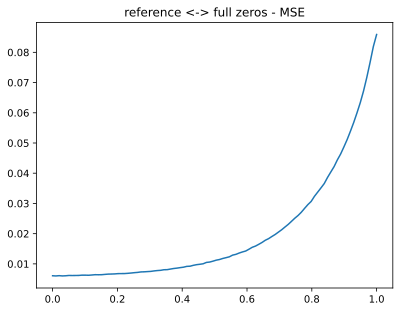

In [57]:
params_1 = mi.TensorXf(params_ref[Scene.COND1])
params_2 = mi.TensorXf(np.zeros((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> full zeros - MSE", loss_fn=mse)

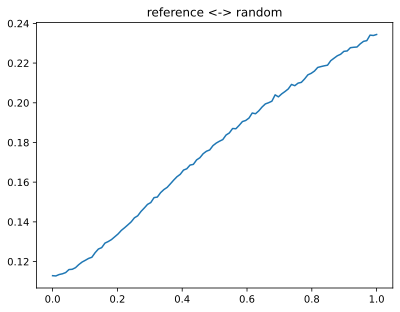

In [18]:
params_1 = mi.TensorXf(params_ref[Scene.COND1])
params_2 = generate_random_texture(Scene.COND1, seed=0)
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> random")

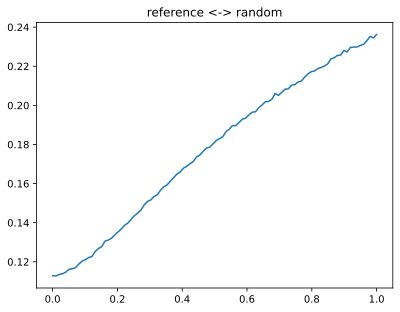

In [19]:
params_1 = mi.TensorXf(params_ref[Scene.COND1])
params_2 = generate_random_texture(Scene.COND1, seed=1)
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> random")

## Scene 2

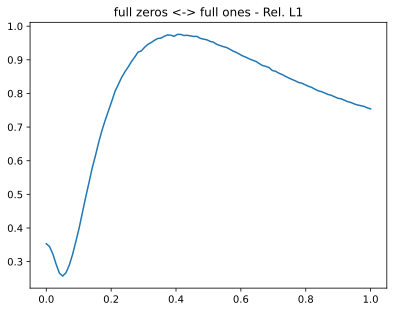

In [47]:
params_1 = mi.TensorXf(np.zeros((512, 512, 1)))
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="full zeros <-> full ones - Rel. L1", loss_fn=rel_l1_loss)

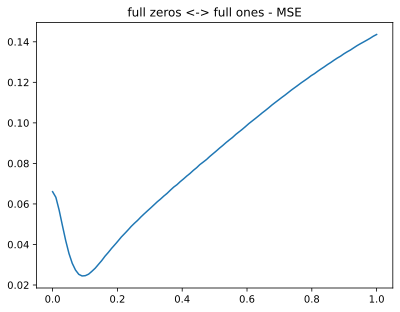

In [49]:
params_1 = mi.TensorXf(np.zeros((512, 512, 1)))
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="full zeros <-> full ones - MSE", loss_fn=mse)

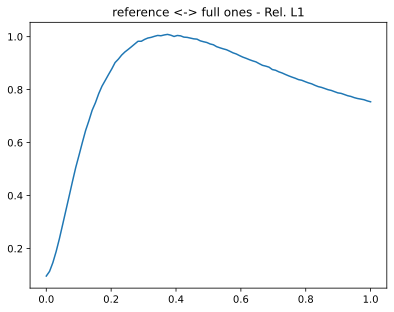

In [50]:
params_1 = mi.TensorXf(params_ref[Scene.COND2])
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> full ones - Rel. L1", loss_fn=rel_l1_loss)

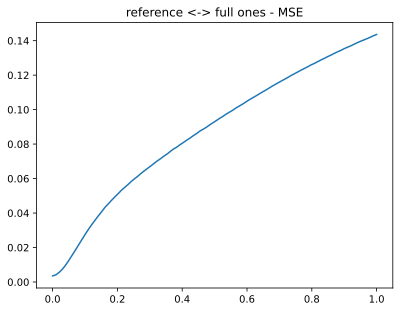

In [51]:
params_1 = mi.TensorXf(params_ref[Scene.COND2])
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> full ones - MSE", loss_fn=mse)

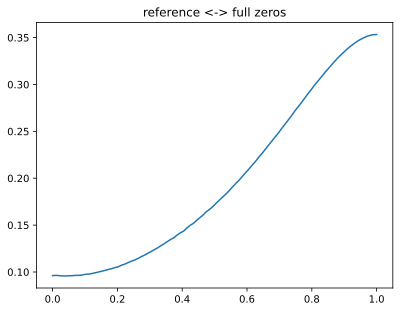

In [22]:
params_1 = mi.TensorXf(params_ref[Scene.COND2])
params_2 = mi.TensorXf(np.zeros((512, 512, 1)))
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> full zeros")

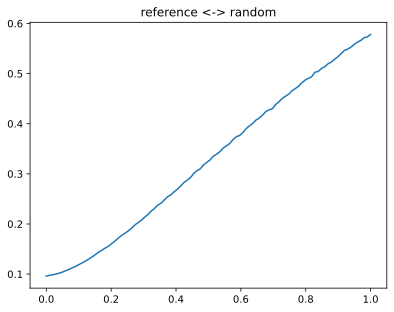

In [23]:
params_1 = mi.TensorXf(params_ref[Scene.COND2])
params_2 = generate_random_texture(Scene.COND2, seed=0)
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> random")

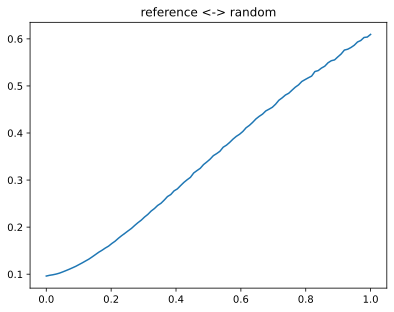

In [24]:
params_1 = mi.TensorXf(params_ref[Scene.COND2])
params_2 = generate_random_texture(Scene.COND2, seed=1)
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> random")

# Contour plot experiments

Scene 1

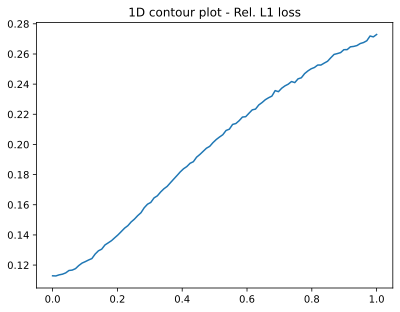

In [45]:
params = mi.TensorXf(params_ref[Scene.COND1])
dir = 0.2*mi.TensorXf(np.ones((512, 512, 1)))
contour_plot_1d(Scene.COND1, params, dir, title="1D contour plot - Rel. L1 loss", loss_fn=rel_l1_loss)

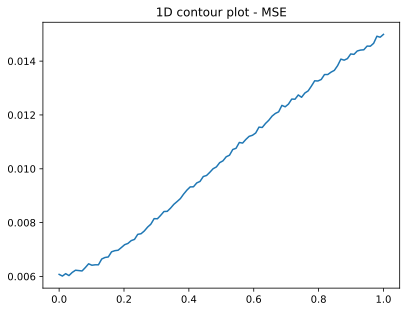

In [46]:
params = mi.TensorXf(params_ref[Scene.COND1])
dir = 0.2*mi.TensorXf(np.ones((512, 512, 1)))
contour_plot_1d(Scene.COND1, params, dir, title="1D contour plot - MSE", loss_fn=mse)

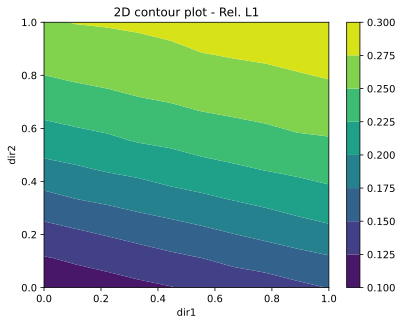

In [43]:
params = mi.TensorXf(params_ref[Scene.COND1])
dir1 = 0.2*mi.TensorXf(np.ones((512, 512, 1)))
dir2 = 0.2*generate_random_texture(Scene.COND1, seed=0)
contour_plot_2d(Scene.COND1, params, dir1, dir2, title="2D contour plot - Rel. L1", loss_fn=rel_l1_loss)

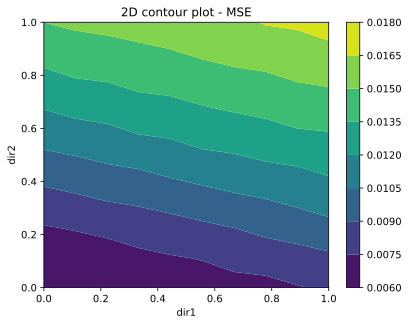

In [44]:
params = mi.TensorXf(params_ref[Scene.COND1])
dir1 = 0.2*mi.TensorXf(np.ones((512, 512, 1)))
dir2 = 0.2*generate_random_texture(Scene.COND1, seed=0)
contour_plot_2d(Scene.COND1, params, dir1, dir2, title="2D contour plot - MSE", loss_fn=mse)

Scene 2

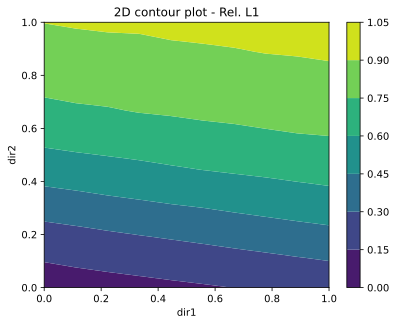

In [41]:
params = mi.TensorXf(params_ref[Scene.COND2])
dir1 = 0.2*mi.TensorXf(np.ones((512, 512, 1)))
dir2 = 0.2*generate_random_texture(Scene.COND2, seed=0)
contour_plot_2d(Scene.COND2, params, dir1, dir2, title="2D contour plot - Rel. L1", loss_fn=rel_l1_loss)

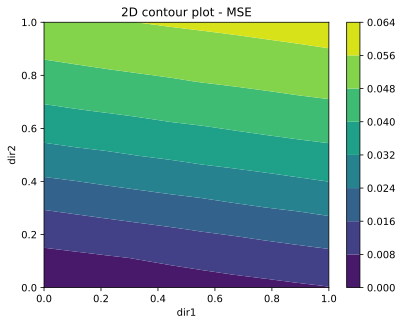

In [42]:
params = mi.TensorXf(params_ref[Scene.COND2])
dir1 = 0.2*mi.TensorXf(np.ones((512, 512, 1)))
dir2 = 0.2*generate_random_texture(Scene.COND2, seed=0)
contour_plot_2d(Scene.COND2, params, dir1, dir2, title="2D contour plot - MSE", loss_fn=mse)

# Bilinear interpolation

Scene 1

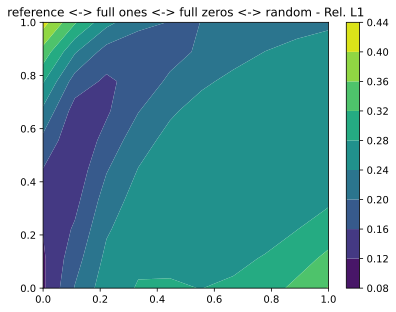

In [37]:
params_1 = mi.TensorXf(params_ref[Scene.COND1])
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
params_3 = mi.TensorXf(np.zeros((512, 512, 1)))
params_4 = generate_random_texture(Scene.COND1, seed=0)
plot_loss_bilinear_interp_2D(Scene.COND1, params_1, params_2, params_3, params_4, title="reference <-> full ones <-> full zeros <-> random - Rel. L1", loss_fn=rel_l1_loss)

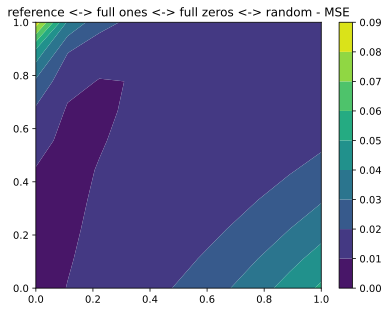

In [38]:
params_1 = mi.TensorXf(params_ref[Scene.COND1])
params_2 = mi.TensorXf(np.ones((512, 512, 1)))
params_3 = mi.TensorXf(np.zeros((512, 512, 1)))
params_4 = generate_random_texture(Scene.COND1, seed=0)
plot_loss_bilinear_interp_2D(Scene.COND1, params_1, params_2, params_3, params_4, title="reference <-> full ones <-> full zeros <-> random - MSE", loss_fn=mse)

Scene 2

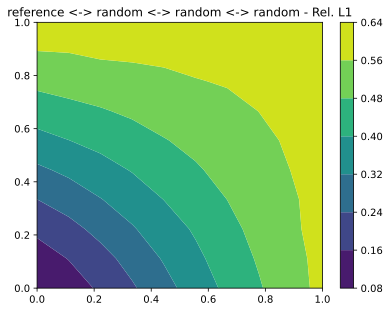

In [39]:
params_1 = mi.TensorXf(params_ref[Scene.COND2])
params_2 = generate_random_texture(Scene.COND2, seed=0)
params_3 = generate_random_texture(Scene.COND2, seed=1)
params_4 = generate_random_texture(Scene.COND2, seed=2)
plot_loss_bilinear_interp_2D(Scene.COND2, params_1, params_2, params_3, params_4, title="reference <-> random <-> random <-> random - Rel. L1", loss_fn=rel_l1_loss)

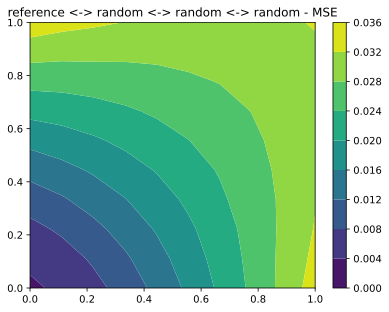

In [40]:
params_1 = mi.TensorXf(params_ref[Scene.COND2])
params_2 = generate_random_texture(Scene.COND2, seed=0)
params_3 = generate_random_texture(Scene.COND2, seed=1)
params_4 = generate_random_texture(Scene.COND2, seed=2)
plot_loss_bilinear_interp_2D(Scene.COND2, params_1, params_2, params_3, params_4, title="reference <-> random <-> random <-> random - MSE", loss_fn=mse)